<a href="https://colab.research.google.com/github/monroews/CEE3530/blob/master/Examples/Adsorption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install aguaclara


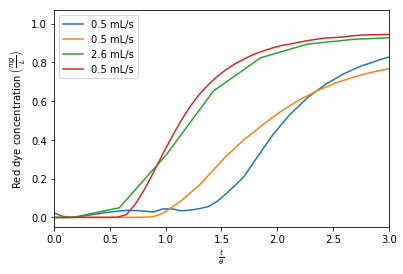

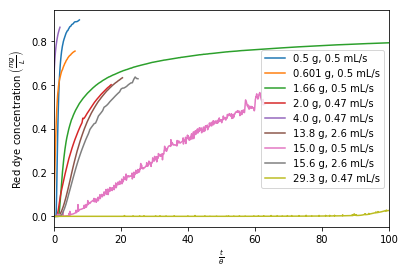

In [11]:
from aguaclara.core.units import unit_registry as u
import aguaclara.research.environmental_processes_analysis as epa
import aguaclara.core.physchem as pc
import aguaclara.core.utility as ut
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
from pathlib import Path
import pandas as pd
pc.density_water(20*u.degC)



def adsorption_data(C_column, dirpath):
    """This function extracts the data from folder containing tab delimited
    files of adsorption data. The file must be the original tab delimited file.

    Parameters
    ----------
    C_column : int
        index of the column that contains the dissolved oxygen concentration
        data.
    dirpath : string
        path to the directory containing aeration data you want to analyze
    Returns
    -------
    filepaths : string list
        all file paths in the directory sorted by flow rate
    time_data : numpy array list
        sorted list of numpy arrays containing the times with units of seconds
    Examples
    --------
    """
    #return the list of files in the directory
    metadata = pd.read_csv(dirpath + '/metadata.txt', delimiter='\t')
    filenames = metadata['file name']
    #extract the flowrates from the filenames and apply units
    #sort airflows and filenames so that they are in ascending order of flow rates


    filepaths = [dirpath + '/' + i for i in filenames]
    #C_data is a list of numpy arrays. Thus each of the numpy data arrays can have different lengths to accommodate short and long experiments
    # cycle through all of the files and extract the column of data with oxygen concentrations and the times
    C_data=[epa.column_of_data(i,epa.notes(i).last_valid_index() + 1,C_column,-1,'mg/L') for i in filepaths]
    time_data=[(epa.column_of_time(i,epa.notes(i).last_valid_index() + 1,-1)).to(u.s) for i in filepaths]

    adsorption_collection = collections.namedtuple('adsorption_results','metadata filenames C_data time_data')
    adsorption_results = adsorption_collection(metadata, filenames, C_data, time_data)
    return adsorption_results


C_column = 1
dirpath = "https://raw.githubusercontent.com/monroews/CEE3530/master/Examples/data/Adsorption"



metadata, filenames, C_data, time_data = adsorption_data(C_column,dirpath)
metadata
Column_D = 1 * u.inch
Column_A = pc.area_circle(Column_D)
Column_L = 15.2 * u.cm
Column_V = Column_A * Column_L
#I'm guessing at the volume of water in the tubing, in the photometer, and in the space above and below the column. This parameter could be adjusted!
Tubing_V = 60 * u.mL
Flow_rate = ([metadata['flow (mL/s)'][i] for i in metadata.index])* u.mL/u.s
Mass_carbon= ([metadata['carbon (g)'][i] for i in metadata.index])* u.g
Tubing_HRT = Tubing_V/Flow_rate
#to make things simple we are assuming that the porosity is the same for sand and for activated carbon. That is likely not true!
porosity = 0.4
C_0 = 50 * u.mg/u.L

#estimate the HRT for all of the columns
HRT = (porosity * Column_V/Flow_rate).to(u.s)

#zero the concentration data by subtracting the value of the first data point from all data points. Do this in each data set.
for i in range(np.size(filenames)):
  C_data[i]=C_data[i]-C_data[i][0]


#Create a graph of the columns that didn't have any activated carbon
mylegend = []
for i in range(np.size(filenames)):
  if (metadata['carbon (g)'][i] == 0):
    plt.plot(time_data[i]/HRT[i] - Tubing_HRT[i]/HRT[i], C_data[i]/C_0,'-');
    mylegend.append(str(metadata['flow (mL/s)'][i]) + ' mL/s')

plt.xlabel(r'$\frac{t}{\theta}$');
plt.xlim(right=3,left=0);
plt.ylabel(r'Red dye concentration $\left ( \frac{mg}{L} \right )$');
plt.legend(mylegend);
plt.show()

# create a graph of the columns that had different masses of activated carbon. Note that this includes systems with different flow rates!
mylegend =[]
for i in range(np.size(filenames)):
  if (metadata['carbon (g)'][i] != 0):
    plt.plot(time_data[i]/HRT[i] - Tubing_HRT[i]/HRT[i], C_data[i]/C_0,'-');
    mylegend.append(str(ut.round_sf(metadata['carbon (g)'][i],3)) + ' g, ' + str(ut.round_sf(metadata['flow (mL/s)'][i],2)) + ' mL/s')

plt.xlabel(r'$\frac{t}{\theta}$');
plt.xlim(right=100,left=0);
plt.ylabel(r'Red dye concentration $\left ( \frac{mg}{L} \right )$');
plt.legend(mylegend);
plt.show()